In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import pandas as pd

### Import raw data (Note: check working directory!!)

In [3]:
# Each of the following opens the same Excel file but 
# reads a specific worksheet and then creates a DataFrame object
rawDataMK = pd.read_excel("data.xlsx", sheet_name="TRD_Index", header=0)
rawDataXA = pd.read_excel("data.xlsx", sheet_name="xin_an", header=0)

In [4]:
rawDataMK.head()

,Code,Date,Open,High,Low,Close
0,1,2014-01-02,2112.126,2113.110,2101.016,2109.387
1,1,2014-01-03,2101.542,2102.167,2075.899,2083.136
2,1,2014-01-06,2078.684,2078.684,2034.006,2045.709
3,1,2014-01-07,2034.224,2052.279,2029.246,2047.317
4,1,2014-01-08,2047.256,2062.952,2037.110,2044.340


In [5]:
rawDataXA.head()

,Date,Open,High,Low,Close,Volume
0,2014-01-01,10.59,10.59,10.59,10.59,0
1,2014-01-02,10.62,10.99,10.58,10.96,10984100
2,2014-01-03,10.89,11.04,10.71,10.85,7629900
3,2014-01-06,10.83,10.83,10.00,10.10,14364700
4,2014-01-07,10.05,10.22,9.95,10.11,5219100


In [6]:
# Use 'shape' attribute to see the size of each DataFrame: (no. of rows, no. of columns)
rawDataMK.shape, rawDataXA.shape

((4665, 6), (260, 6))

### Data pre-processing

In [7]:
# Select data where Code == 902 (Market)
dataMK = rawDataMK[rawDataMK.Code == 902]
dataMK.shape

(311, 6)

In [8]:
from numpy import log

In [9]:
# Process MK
# [1:] means exclude index 0; [:-1] means exclude last index
reMK = log(dataMK.Close[1:].values) - log(dataMK.Close[:-1].values)
reMK = pd.Series(reMK, name='ReturnMK')  # creates a pandas series with the indicated column name
dataMK = pd.concat([dataMK[1:].reset_index(drop=True), reMK], axis=1) # axis=1 is simialr to R's cbind()
dataMK = dataMK[['Date','ReturnMK']] # keep only these 2 columns 

In [10]:
dataMK.shape

(310, 2)

In [11]:
dataMK.head()

,Date,ReturnMK
0,2014-01-03,-0.009050
1,2014-01-06,-0.024959
2,2014-01-07,0.003793
3,2014-01-08,0.004120
4,2014-01-09,-0.011565


In [12]:
# Now repeat the above steps for XA
dataXA = rawDataXA[rawDataXA.Volume != 0]   # rows with non-zero volumes

reXA = log(dataXA.Close[1:].values) - log(dataXA.Close[:-1].values)
reXA = pd.Series(reXA, name='ReturnXA')
dataXA = pd.concat([dataXA[1:].reset_index(drop=True), reXA], axis=1)
dataXA = dataXA[['Date','ReturnXA']] # keep only these 2 columns 

In [13]:
dataXA.shape

(243, 2)

In [14]:
# Merge two tables (inner join) on the column 'Date'
dataMX = pd.merge(dataMK, dataXA, how='inner', on='Date')

In [15]:
dataMX.shape

(243, 3)

In [16]:
dataMX.head()

,Date,ReturnMK,ReturnXA
0,2014-01-03,-0.009050,-0.010087
1,2014-01-06,-0.024959,-0.071630
2,2014-01-07,0.003793,0.000990
3,2014-01-08,0.004120,-0.004958
4,2014-01-09,-0.011565,-0.018055


### Regression

In [17]:
from statsmodels.formula.api import ols

In [18]:
#dataMX = dataMX[:-1]   # last record has an undefined return, so remove it 
Rf = 0.036 / 365
Ri = dataMX.ReturnXA - Rf
Rm = dataMX.ReturnMK - Rf
df = pd.DataFrame({'Ri':Ri, 'Rm':Rm})   # create a DataFrame containing these 2 columns

In [19]:
df.tail()

,Ri,Rm
238,-0.000099,0.023893
239,0.003619,0.020075
240,-0.028323,-0.006055
241,-0.015484,-0.008189
242,0.005698,0.015612


In [20]:
model = ols('Ri ~ Rm', df)       # ols = Ordinary Least Square
results = model.fit(missing='drop')
results.params

Intercept   -0.001939
Rm           1.132173
dtype: float64

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     77.66
Date:                Thu, 11 Apr 2019   Prob (F-statistic):           2.48e-16
Time:                        19:32:06   Log-Likelihood:                 579.53
No. Observations:                 243   AIC:                            -1155.
Df Residuals:                     241   BIC:                            -1148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0019      0.001     -1.340      0.182      -0.005       0.001
Rm             1.1322      0.128      8.812      0.000       0.879       1.385
==============================================================================
Omnibus:                       40.005   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.445
Skew:                           0.462   Prob(JB):                     1.22e-46
Kurtosis:                       7.475   Cond. No.                         89.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Scatterplot and regresson line 

In [22]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

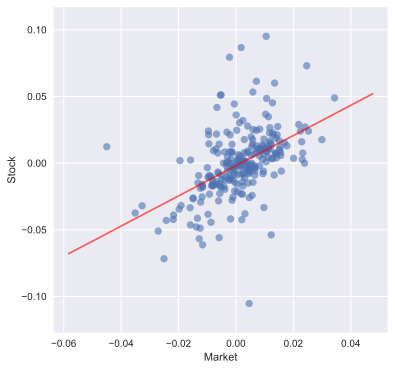

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

# scatter plot
ax.scatter(Rm, Ri, alpha=0.6)

# regression line
xmin = Rm.min()
xmax = Rm.max()
xrange = xmax - xmin
ext = xrange/6.0 # extend x range

intercept, slope = results.params
x = np.linspace(xmin - ext, xmax + ext, 2)  # 2 points define a straight line
ax.plot(x, intercept + slope * x, color='r', alpha=0.6)
#ax.plot(Rm, results.fittedvalues, color='r', alpha=0.6)  # this also works
ax.set_xlabel('Market')
ax.set_ylabel('Stock')
plt.show()
